# Band Gap, Formation Energy, and Volume Prediction using *Ward 2016* Method

This notebook uses the method from [Ward 2016](https://www.nature.com/articles/npjcompumats201628) to predict band gap, formation energy, and specific volume of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.descriptors import composition_features as cp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~300000 compounds with data extracted from the Open Quantum Materials Database (OQMD)

In [2]:
training_file = "datasets/oqmd_all.data"

training_set = pd.read_table(training_file, sep='  ', engine='python')

training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability
0,Li1,-1.89200154333,17.8351,None,0.0,0.004605,0.00460472666667
1,Mg1,-1.53960357333,22.9639,None,0.0,0.002719,0.00271877166667
2,Kr1,0.01125595,41.4146,None,7.367,0.015315,0.015314775
3,Na1,-1.29910061667,32.9826,None,0.0,0.003780,0.00377956333333
4,Pd1,-5.15853261667,15.2088,None,0.0,0.018186,0.0181856433333
5,Fe1,-8.12584908667,11.5973,2.52045186667,0.0,0.182049,0.182048713333
6,Gd1,-4.65402404333,32.2627,-0.00223023333333,0.0,0.001047,0.00104724916667
7,Hf1,-9.92320232,22.3676,-6.75333333333e-05,0.0,0.032166,0.032166465
8,Ho1,-4.57662735,30.5482,0.0072197,0.0,0.000166,0.00055882666667
9,In1,-2.71482552333,26.816,None,0.0,0.005113,0.00511323666667


### Remove energy outlier from dataset

In [3]:
training_set = training_set.replace("None", np.nan)

In [4]:
print min(np.array(training_set["energy_pa"], dtype=float))
print np.argmin(training_set["energy_pa"])

-144.375915035
339163


In [5]:
min_value = min(np.array(training_set["energy_pa"], dtype=float))
training_set = training_set.replace(str(min_value), np.nan)

In [6]:
print min(np.array(training_set["energy_pa"], dtype=float))
print np.argmin(np.array(training_set["energy_pa"], dtype=float))

-14.29838348
339163


### Get groundstate of each compound

For compounds that appear more than once in the training set, only the lowest energy state is kept.

In [7]:
training_set['is_groundstate'] = False

In [8]:
%%time
for gid,group in training_set.groupby('comp'):
    group = group.sort_values('energy_pa', ascending=True)
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True

CPU times: user 3min 36s, sys: 1.22 s, total: 3min 37s
Wall time: 3min 39s


In [9]:
original_count = len(training_set)
training_set = training_set[training_set['is_groundstate']]
print('Removed %d/%d entires'%(original_count - len(training_set), original_count))

Removed 118653/347329 entires


## Create PyMatGen Composition objects

In [10]:
comp_objects = [Composition(comp) for comp in training_set["comp"]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj
62,Ne1,-0.02918079,21.7199,NaN,11.91,0.000137,0.00013712,True,(Ne)
65,Kr1,-0.0013236,42.8308,NaN,7.487,0.002735,0.002735225,True,(Kr)
159,B1Tc1,-7.80049421,13.1945,0.00272175,0.0,0.718864,1.10374534647,True,"(Tc, B)"
679,B1Ti1,-6.466448975,15.2648,-0.0002029,0.0,0.742588,1.5733130325,True,"(B, Ti)"
993,P1Pt1Tm1,-6.64505789667,18.5932,0.000486633333333,0.0,-1.425193,7.60066666701e-05,True,"(Tm, Pt, P)"
1007,B2Zr1,-8.29272135667,10.3174,0.000221233333333,0.0,-0.991686,4.2519999999e-05,True,"(Zr, B)"
1060,P1Pt1Tb1,-6.72520022333,19.2908,0.0004226,0.0,-1.234425,0.00012312666667,True,"(Tb, Pt, P)"
1066,H2Th1,-5.19737278,13.4329,0.0002352,0.0,-0.483323,0.0119890655755,True,"(H, Th)"
1075,Al1B2,-5.74446877667,8.51817,NaN,0.0,-0.043911,9.43066666667e-05,True,"(B, Al)"
1084,B2Mo1,-8.34425296333,8.83242,-9.54333333333e-05,0.0,-0.276247,0.15837163,True,"(Mo, B)"


## Compute descriptors using MatMiner
Here, we compute 145 composition based attributes as described in *Ward 2016* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [11]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.StoichAttribute().featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElemPropertyAttribute().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbitalAttribute().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.IonicAttribute().featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

#%lprun -f calc_attributes calc_attributes()

all_descriptors, attr_names = calc_attributes(training_set)
print np.shape(all_descriptors)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


(228676, 158)
CPU times: user 5min 31s, sys: 6.02 s, total: 5min 37s
Wall time: 5min 35s


## Predicting band gaps

In [12]:
#Drop NaN values from training set
training_set_use = all_descriptors.replace("None", np.nan)
training_set_use = all_descriptors.replace(np.inf, np.nan)
training_set_use = training_set_use.dropna()

training_set_use

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj,0-norm,...,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons,Avg Ionic Char,Max Ionic Char,compound possible
159,B1Tc1,-7.80049421,13.1945,0.00272175,0.0,0.718864,1.10374534647,True,"(Tc, B)",2.0,...,0.000000,0.500000,2.000000,0.500000,0.000000,0.100000,0.400000,0.001222,0.004888,0.0
679,B1Ti1,-6.466448975,15.2648,-0.0002029,0.0,0.742588,1.5733130325,True,"(B, Ti)",2.0,...,0.000000,0.500000,2.000000,0.285714,0.000000,0.142857,0.571429,0.015147,0.060587,0.0
993,P1Pt1Tm1,-6.64505789667,18.5932,0.000486633333333,0.0,-1.425193,7.60066666701e-05,True,"(Tm, Pt, P)",3.0,...,9.000000,1.000000,1.666667,0.204545,0.613636,0.068182,0.113636,0.048133,0.232967,0.0
1007,B2Zr1,-8.29272135667,10.3174,0.000221233333333,0.0,-0.991686,4.2519999999e-05,True,"(Zr, B)",2.0,...,0.000000,0.666667,2.000000,0.200000,0.000000,0.200000,0.600000,0.026313,0.118407,0.0
1060,P1Pt1Tb1,-6.72520022333,19.2908,0.0004226,0.0,-1.234425,0.00012312666667,True,"(Tb, Pt, P)",3.0,...,7.666667,1.000000,1.666667,0.225000,0.575000,0.075000,0.125000,0.051598,0.248906,0.0
1066,H2Th1,-5.19737278,13.4329,0.0002352,0.0,-0.483323,0.0119890655755,True,"(H, Th)",2.0,...,0.000000,0.000000,1.333333,0.333333,0.000000,0.000000,0.666667,0.040736,0.183314,0.0
1084,B2Mo1,-8.34425296333,8.83242,-9.54333333333e-05,0.0,-0.276247,0.15837163,True,"(Mo, B)",2.0,...,0.000000,0.666667,1.666667,0.416667,0.000000,0.166667,0.416667,0.000799,0.003594,0.0
1087,Au1Si1Th1,-6.14412136333,22.4375,0.0008936,0.0,-0.775884,6.73933333329e-05,True,"(Th, Si, Au)",3.0,...,4.666667,0.666667,1.666667,0.363636,0.424242,0.060606,0.151515,0.055838,0.319141,0.0
1095,B2Y1,-7.17037009333,12.1023,0.000981466666667,0.0,-0.563585,3.429e-05,True,"(B, Y)",2.0,...,0.000000,0.666667,2.000000,0.111111,0.000000,0.222222,0.666667,0.034385,0.154731,0.0
1130,P1Pt1Y1,-7.33500527333,19.2808,0.000478433333333,0.0,-1.452008,0.00035125,True,"(P, Pt, Y)",3.0,...,4.666667,1.000000,1.666667,0.312500,0.437500,0.093750,0.156250,0.050725,0.244896,0.0


In [13]:
#Band gap data
bandgaps = np.array(training_set_use["bandgap"], dtype=float)
print bandgaps

#Band gap range data
bg_range = np.zeros(np.shape(bandgaps), dtype=str)
for i in range(len(bandgaps)):
    if bandgaps[i] == 0:
        bg_range[i] = "0"
    elif bandgaps[i] > 0 and bandgaps[i] < 1.5:
        bg_range[i] = "1"
    elif bandgaps[i] >= 1.5 and bandgaps[i] < 3.0:
        bg_range[i] = "2"
    elif bandgaps[i] >= 3.0:
        bg_range[i] = "3"

[ 0.  0.  0. ...,  0.  0.  0.]


### Predict band gap range using classifiers

In [14]:
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], bg_range)
prediction = model1.predict(training_set_use[attr_names])

In [15]:
pd.crosstab(bg_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,,0,1,2,3
actual,,,,,
,1,0,0,0,0
0,0,111113,3,2,1
1,0,74,1267,4,0
2,0,16,10,908,3
3,0,5,0,4,370


In [16]:
model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], bg_range)
prediction = model2.predict(training_set_use[attr_names])

In [17]:
pd.crosstab(bg_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,,0,1,2,3
actual,,,,,
,1,0,0,0,0
0,0,111119,0,0,0
1,0,0,1345,0,0
2,0,0,0,937,0
3,0,0,0,0,379


In [18]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], bandgaps)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
prediction = rf_model.predict(training_set_use[attr_names])

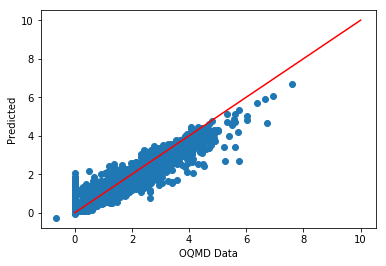

In [20]:
plt.scatter(bandgaps, prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [21]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.044168406428
CPU times: user 10min 13s, sys: 1.55 s, total: 10min 15s
Wall time: 10min 16s


### Decision Tree Regressor

In [22]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], bandgaps)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [23]:
dt_prediction = dt_model.predict(training_set_use[attr_names])

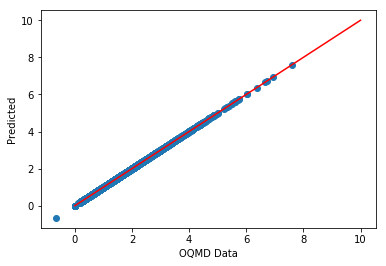

In [24]:
plt.scatter(bandgaps, dt_prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [25]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.0490312011881
CPU times: user 1min 35s, sys: 496 ms, total: 1min 36s
Wall time: 1min 36s


## Predicting formation energy

In [26]:
#Discretize into positive/negative formation energy

delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['p' 'p' 'n' ..., 'n' 'n' 'n']


In [27]:
#Random Forest Classifier

model1 = RandomForestClassifier(n_estimators=8, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [28]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,29897,95
p,285,83504


In [29]:
#Decision Trees Classifier

model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], energy_range)
prediction = model2.predict(training_set_use[attr_names])

In [30]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,29992,0
p,0,83789


In [31]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [32]:
prediction = rf_model.predict(training_set_use[attr_names])

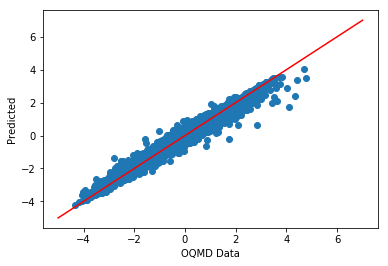

In [33]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [34]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.193275439716
CPU times: user 9min 17s, sys: 1.92 s, total: 9min 19s
Wall time: 9min 19s


### Decision Tree

In [35]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], delta_e)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [36]:
prediction = dt_model.predict(training_set_use[attr_names])

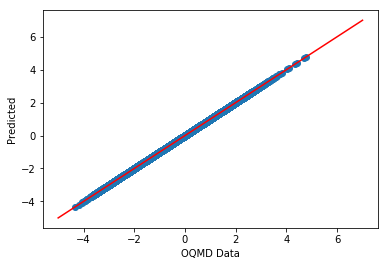

In [37]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [38]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.261895103559
CPU times: user 1min 28s, sys: 796 ms, total: 1min 29s
Wall time: 1min 29s


## Predicting volume per atom

In [39]:
#Remove volume outlier
max_value = max(np.array(training_set_use["volume_pa"], dtype=float))
print max_value
training_set_vol = training_set_use.replace(str(max_value), np.nan)
print max(np.array(training_set_vol["volume_pa"], dtype=float))

1017.15
136.531


In [40]:
training_set_vol = training_set_vol.dropna()

In [41]:
volume_pa = np.array(training_set_vol["volume_pa"], dtype=float)
print volume_pa

#Band gap range data
vol_range = np.zeros(np.shape(volume_pa), dtype=str)
for i in range(len(volume_pa)):
    if volume_pa[i] < 20:
        vol_range[i] = "0"
    elif volume_pa[i] >= 20 and volume_pa[i] < 40:
        vol_range[i] = "1"
    elif volume_pa[i] >= 40 and volume_pa[i] < 60:
        vol_range[i] = "2"
    elif volume_pa[i] >= 60:
        vol_range[i] = "3"


[ 13.1945   15.2648   18.5932  ...,   9.95938   9.55423  11.9021 ]


In [42]:
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_vol[attr_names], vol_range)
prediction = model1.predict(training_set_vol[attr_names])

In [43]:
pd.crosstab(vol_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,48965,36,0,0
1,118,60791,5,0
2,1,42,3559,1
3,0,1,6,255


In [44]:
model2 = DecisionTreeClassifier()
model2.fit(training_set_vol[attr_names], vol_range)
prediction = model2.predict(training_set_vol[attr_names])

In [45]:
pd.crosstab(vol_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,49001,0,0,0
1,0,60914,0,0
2,0,0,3603,0
3,0,0,0,262


In [46]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_vol[attr_names], volume_pa)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [47]:
prediction = rf_model.predict(training_set_vol[attr_names])

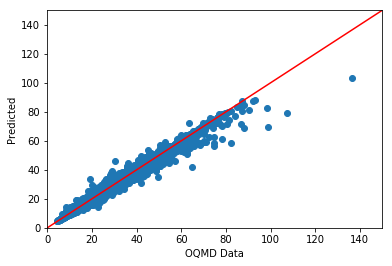

In [48]:
plt.scatter(volume_pa, prediction)
plt.plot(range(0,151), range(0,151), 'r')
plt.axis([0,150,0,150])
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [49]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_vol[attr_names], volume_pa, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

1.27838215074
CPU times: user 9min 4s, sys: 2.92 s, total: 9min 7s
Wall time: 9min 9s
